# Star/Galaxy/QSO Classification in DECaLS
by Stéphanie Juneau, Robert Nikutta, Knut Olsen and the NOAO Data Lab Team

In this notebook, we investigate the optical and infrared colors of astronomical sources detected in the DECam Legacy Survey (DECaLS), which comprises stars, galaxies and quasars (or QSOs, which stands for Quasi-Stellar Objects). We will plot color combinations, and take into account the source "type" as defined from the shape of its light profile. 

You can read more about DECaLS [here](http://datalab.noao.edu/decals/ls.php) and [here](http://legacysurvey.org).

Several extensions of this work are possible. For example, one could add more detailed information from the shape parameters and/or spectroscopic information from SDSS/BOSS (see the [Hack Ideas](#hacks) section at the end of this notebook!).

# Import and Authenticate

In [2]:
# Import packages including some Data Lab (dl) specific ones.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline

from dl import helpers

from cStringIO import StringIO  #C script to handle string format
from astropy.table import Table
print 'Done importing'

Q = helpers.Querist('anonymous')
print 'Done getting token'

Done importing
Done getting token


# Introduction

*Ellipticals are red; Spirals are blue.*

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxies, and background galaxies at various distances, including QSOs (quasi-stellar objects) with actively accreting supermassive black holes.

<figure>
<img src="Figs/DECaLS_noLabels.jpg", align="center", width=700>
<figcaption>**Figure 1.** Small section of the DECaLS DR3 image from the Legacy Survey [viewer](http://legacysurvey.org/viewer) around RA=253.3, Dec=29.2 degrees.</figcaption>
</figure>

In preparation for DESI ([Dark Energy Spectroscopic Experiment](http://desi.lbl.gov)), the imaging Legacy Survey (including DECaLS) will be used to select over 30 million targets for the spectroscopy campain. The main DESI sample will comprise emission-line galaxies (ELGs), luminous red galaxies (LRGs), and QSOs. There will also be a Bright Galaxy Survey (BGS) targetting a magnitude-limited sample (r<19.5), including stars within the Milky Way.

<figure>
<img src="Figs/DECaLS_Labels.jpg", align="center", width=700>
<figcaption>**Figure 2.** Same section of the DECaLS DR3 image as in Figure 1 but with labels from a preliminary target selection algorithm (applied to DR2 observations).</figcaption>
</figure>

## Object Shapes/Types

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for DECaLS DR3:
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>SIMP (“simple” galaxies: round, exponential profile with 0.45″ effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>COMP (composite deVaucouleurs+exponential at same centroid)</li>
</ul>

Summary of shape fitting and assignment:
<ol>
<li>Fit all sources with PSF and SIMP; keep if significant (5 sigma); otherwise discard.
<li>If SIMP is better model, fit again with EXP and DEV; keep if 3 sigma improvement
<li>Fit again with COMP (composite of EXP and DEV); keep if further 3 sigma improvement
</ol>

<figure>
<img src="Figs/Gals_Qso.jpg", align="left", width=600>
<figcaption>**Figure 3.** Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

## Magnitudes and Colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. Below, we plot the filter curves from the SDSS survey and those from the DECam (Dark Energy Camera) used to obtain *g,r,z* photometry for the DECaLS survey.

(0, 1.05)

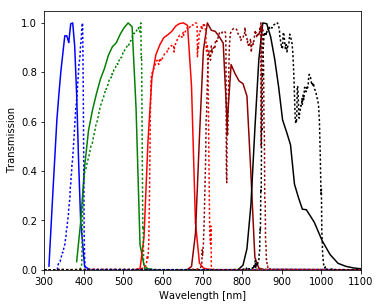

In [3]:
#Read in and plot filters
filters = np.array(['u', 'g', 'r', 'i', 'z'])
filter_colors = np.array(['blue', 'green', 'red', 'darkred', 'black'])

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.7,0.1,0.55,0.6])

#SDSS
for i, filter_name in enumerate(filters):
    filter_data = Table.read('FilterCurves/sdss_filters.'+filter_name, format='ascii', data_start=6, \
                            names=['dum', 'filter_wave', 'transmission'])
    this_wave = filter_data['filter_wave']
    this_trans = filter_data['transmission'] 
    plt.plot(this_wave, this_trans/np.max(this_trans), color=filter_colors[i])

#DECAM
decam_data = Table.read('FilterCurves/DECam_filters.csv', format='ascii')
dc_wave = decam_data['wavelength']
for i, filter_name in enumerate(filters):
    plt.plot(dc_wave, decam_data[filters[i]]/np.max(decam_data[filters[i]]), ':', color=filter_colors[i], label='DECam')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')
plt.xlim([300,1100])
plt.ylim([0,1.05])
#plt.legend()

**Figure 4.** Filter transmission curves for SDSS *u,g,r,i,z* (solid lines), and DECam *u,g,r,i,z* (dotted lines).

In addition to the *g,r,z* bands, photometry was extracted from the infrared [WISE satellite](http://www.nasa.gov/mission_pages/WISE/main/). We use in particular photometry from channels 1 & 2 (*W1, W2*), which are centered around 3.4 and 4.6 microns, respectively.

Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighther in the bluer (i.e., shorter wavelenght) band. Below, we will use the following colors: *g-r*, *r-z*, *z-W1*, *W1-W2*.

# Query DECaLS Tractor Photometry Catalog

The photometry is derived from Tractor modeling of sources.

In [5]:
# Write query statement (adql)
query = """SELECT ra,dec,g,r,z,w1,w2,g_r,r_z,z_w1,w1_w2,type 
         FROM ls_dr3.tractor_primary 
         WHERE (decam_nobs_2>1 and decam_nobs_3>1 and decam_nobs_5>1 
                and g != 'nan' and g != 'inf' and r != 'nan' and r != 'inf' and z != 'nan' and z != 'inf'
                and z_w1 != 'nan' and w1_w2 != 'nan')
         LIMIT 100000"""

# ra, dec      = position of targets
# g,r,z,w1,w2  = photometry in individual bands in AB magnitudes
# g_r, r_z     = pre-computed optical colors g-r and r-z in AB magnitudes
# z_w1         = pre-computed z-band to WISE w1 color in AB mag
# w1_w2        = pre-computed w1-w2 WISE color
# decam_nobs_X = number of observations in bands g (2), r (3) & z (5)
# type         = object type (PSF, SIMP, EXP, DEV, COMP)
#
# WHERE: requirement that there are more than 1 (i.e., at least 2) observation in each DECaLS band

print query

SELECT ra,dec,g,r,z,w1,w2,g_r,r_z,z_w1,w1_w2,type 
         FROM ls_dr3.tractor_primary 
         WHERE (decam_nobs_2>1 and decam_nobs_3>1 and decam_nobs_5>1 
                and g != 'nan' and g != 'inf' and r != 'nan' and r != 'inf' and z != 'nan' and z != 'inf'
                and z_w1 != 'nan' and w1_w2 != 'nan')
         LIMIT 100000


In [6]:
%%time
trac = Q(query,outfmt='table',preview=3)

Returning Astropy Table
RESULT PREVIEW (3 rows)
ra,dec,g,r,z,w1,w2,g_r,r_z,z_w1,w1_w2,type
322.011393363309,11.1522391561877,24.2933,23.013,22.7209,22.1826,21.508,1.28029,0.292123,0.538279,0.674577,SIMP
322.010447585359,11.1562590188377,23.1173,21.909,21.2989,25.9856,22.1262,1.20823,0.610179,-4.68672,3.85939,PSF
322.016979165586,11.1617929560849,23.479,21.9388,20.6984,22.8303,21.7092,1.54018,1.24044,-2.13192,1.12111,PSF
CPU times: user 514 ms, sys: 107 ms, total: 620 ms
Wall time: 4.49 s


In [7]:
trac

ra,dec,g,r,z,w1,w2,g_r,r_z,z_w1,w1_w2,type
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
322.011393363,11.1522391562,24.2933,23.013,22.7209,22.1826,21.508,1.28029,0.292123,0.538279,0.674577,SIMP
322.010447585,11.1562590188,23.1173,21.909,21.2989,25.9856,22.1262,1.20823,0.610179,-4.68672,3.85939,PSF
322.016979166,11.1617929561,23.479,21.9388,20.6984,22.8303,21.7092,1.54018,1.24044,-2.13192,1.12111,PSF
322.012801523,11.1640250496,21.3192,20.4879,19.8617,20.9004,21.0896,0.83132,0.626272,-1.03871,-0.189264,EXP
322.011884265,11.1660325941,22.9513,21.4512,20.0095,20.9322,21.1079,1.50005,1.44174,-0.922666,-0.175699,PSF
322.015315022,11.1642621722,25.1312,23.9178,22.354,20.8887,20.7081,1.21347,1.56378,1.46532,0.180613,PSF
322.01881215,11.1554605125,23.1508,22.4273,21.9694,26.1757,22.4181,0.723434,0.457955,-4.20626,3.75752,PSF
322.022988452,11.1606189102,21.6704,20.1697,18.5152,19.197,19.7127,1.50067,1.65451,-0.681854,-0.515702,PSF
322.023013325,11.1643134993,22.7373,21.2544,19.4006,19.8145,20.5191,1.48293,1.85381,-0.413924,-0.704549,PSF


## Optical Color-Color Diagram



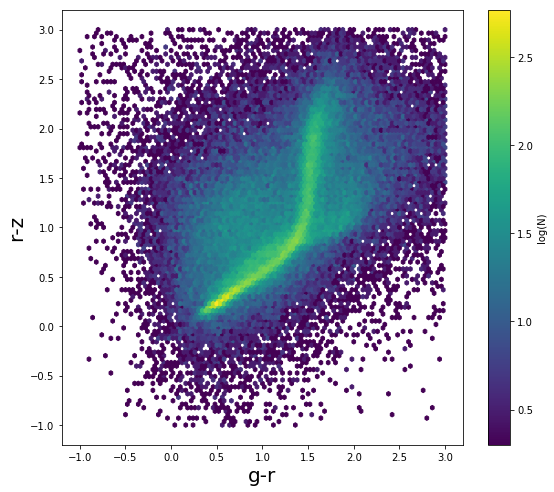

In [8]:
col0 = trac['g_r']  #g-r color
col1 = trac['r_z']  #r-z color

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_ylabel('r-z',fontsize=20)
ax1.set_xlabel('g-r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

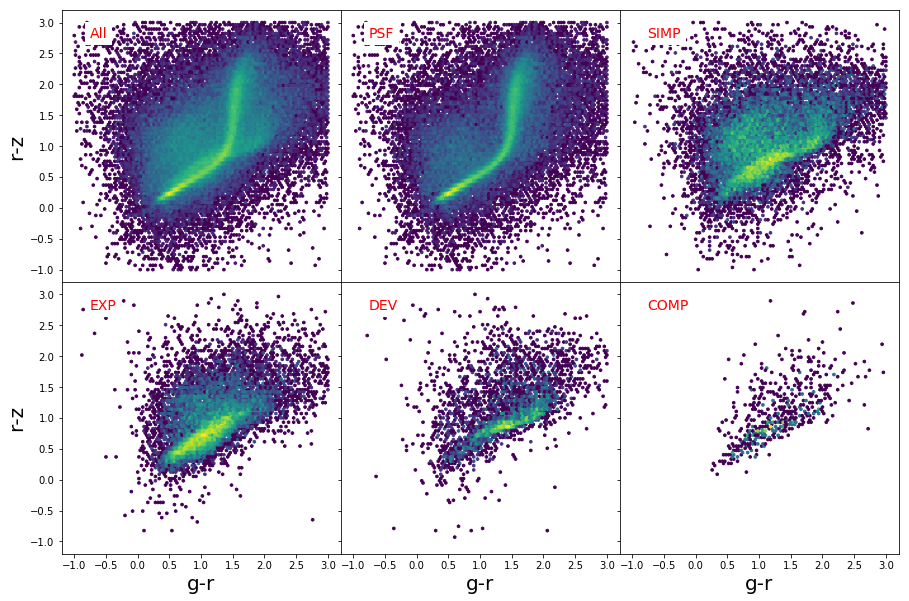

In [9]:
# Classification per object type
objtype = trac['type']

# List of the types
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')   #for All objects: array of 1's
    else:
        selec = (objtype==typ)    #for each type, select on the type parameter
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
    if i>=3: ax.set_xlabel('g-r',fontsize=20)
    if i%3==0: ax.set_ylabel('r-z',fontsize=20)
    ax.text(0.1,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0., hspace=0.)

plt.show()

## Optical-Infrared Colors

Combine information from optical/near-infrared DECam observations and from WISE mid-infrared observations. The latter were extracted using "forced photometry" at the position of DECaLS objects.

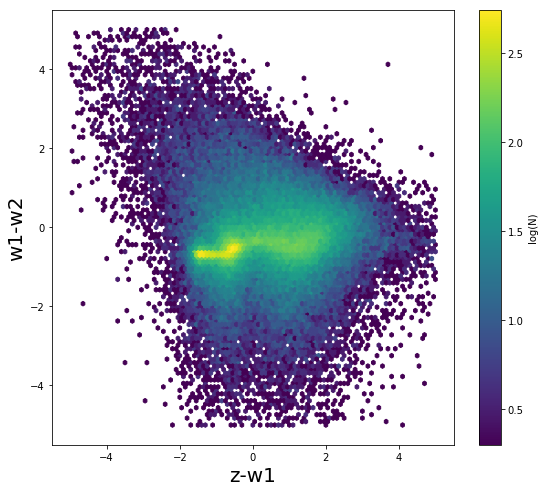

In [10]:
col0 = trac['z_w1']
col1 = trac['w1_w2']

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-5., 5, -5., 5))
ax1.set_ylabel('w1-w2',fontsize=20)
ax1.set_xlabel('z-w1',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

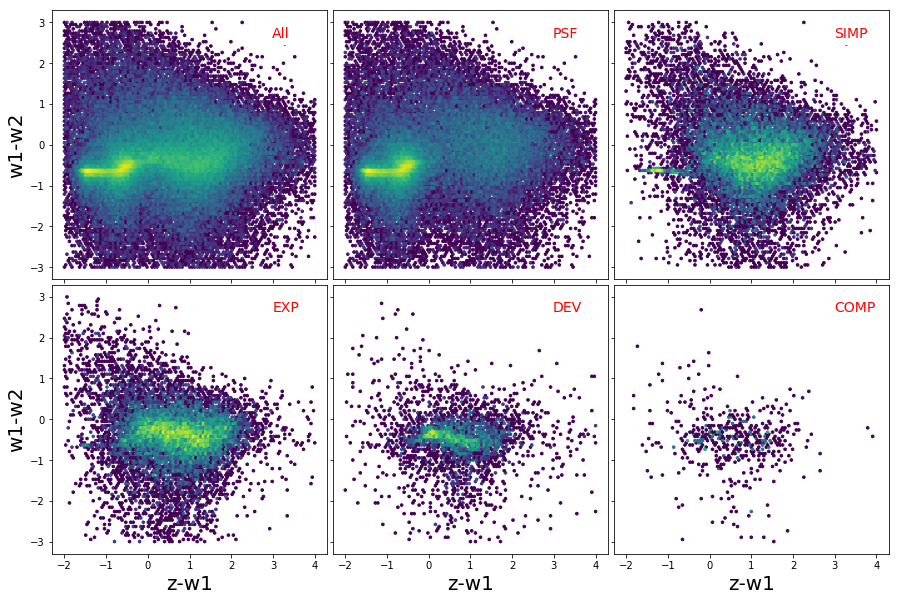

In [11]:
# Classification per object type
objtype = trac['type']

# List
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')
    else:
        selec = (objtype==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-2., 4, -3., 3))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('w1-w2',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

## Image Cutouts for Subset

In [9]:
# Properties for selecting subsamples of interest
objtype = trac['type']
col1 = trac['z_w1']
zmag = trac['z']
w1   = trac['w1']

# Select interesting subset of points
selec = (objtype=='PSF')&(w1>18)&(w1<19)
red   = (col1>1)&(col1<2)
blue  = (col1>-0.8)&(col1<-0.5)

# Retrieve by position (RA, Dec)
ra  = trac['ra']
dec = trac['dec']

idx = np.arange(ra.size)

# Indices fulfilling both criteria
psf_red = idx[selec&red]
psf_blue = idx[selec&blue]

# Random selection
selec_blue = np.random.choice(psf_blue,6,replace=False)
selec_red  = np.random.choice(psf_red,6,replace=False)

ra_blue  = ra[selec_blue]
dec_blue = dec[selec_blue]

ra_red  = ra[selec_red]
dec_red = dec[selec_red]

zmag_blue = zmag[selec_blue]
w1_blue   = w1[selec_blue]
zmag_red  = zmag[selec_red]
w1_red    = w1[selec_red]

In [10]:
def make_cutout_comparison_table(ra_in, dec_in):
    """
    Produces a table comparing DECaLS and SDSS objects side-by-side
    """    
    de_img = []
    wi_img = []
    
    for i in xrange(len(ra_in)):
        de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=decals-dr3&zoom=15&bands=grz' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)
        
        wi_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=unwise-w1w2&zoom=15' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
        wi_img.append(img)

    return de_img,wi_img

In [11]:
def plot_de_wi(de_img,wi_img,zmag,w1mag):
# Plot images in two rows with 6 images in each row
    fig = plt.figure(figsize=(12,4))

    for i in xrange(len(de_img)):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(de_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'z=%.1f'%zmag[i],transform=ax.transAxes,fontsize=12,color='white')

        ax = fig.add_subplot(2,6,i+7)
        ax.imshow(wi_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'W1=%.1f'%w1mag[i],transform=ax.transAxes,fontsize=12,color='white')

    plt.subplots_adjust(wspace=0.02, hspace=0.03)

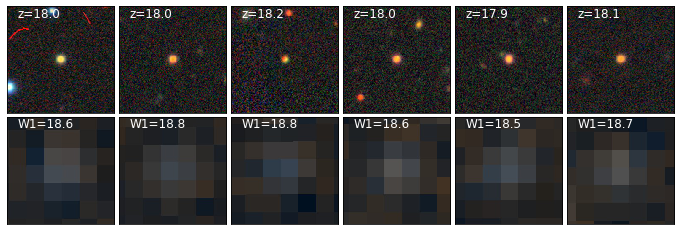

In [12]:
#Plot randomly selected PSF images from the "blue z-W1" side
de_img,wi_img = make_cutout_comparison_table(ra_blue,dec_blue)
plot_de_wi(de_img,wi_img,zmag_blue,w1_blue)

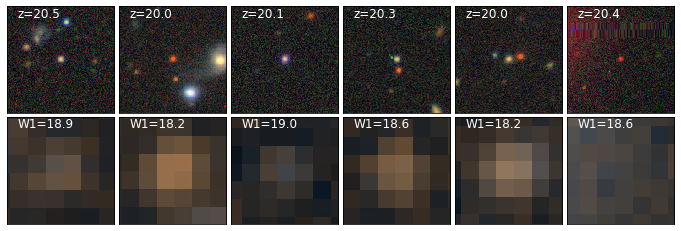

In [13]:
#Plot randomly selected PSF images from the "red z-W1" side
de_img,wi_img = make_cutout_comparison_table(ra_red,dec_red)
plot_de_wi(de_img,wi_img,zmag_red,w1_red)

# Hack Ideas <a class="anchor" id="hacks"></a>

### 1- Combine Colors and Shape (Type) Information
One could work in higher dimensions or optimize a combination of colors (optical and/or infrared) and object type information to optimize classification into star, galaxy & QSO categories.

### 2- Add spectroscopic information from SDSS
There is a Legacy Survey DR3 catalog pre-matched to SDSS DR13 spectroscopy [ls_dr3.dr3_specobj_dr13](http://datalab.noao.edu/tutdev/query.php?name=ls_dr3.dr3_specobj_dr13). One can execute a joint query by joining on "objid" to the "specobjid" from SDSS DR13 [(sdss_dr13.specobj)](http://datalab.noao.edu/tutdev/query.php?name=sdss_dr13.specobj).

### 3- Build a visualisation tool combining image cutouts with location on plots of interest
This could be a tool that either displays randomly (or not) selected targets at the same time on the color-color magnitude diagrams and retrieves cutout. More ambitious would be to write an interactive tool with a cursor selection of a region of interest.

### 4- Apply machine learning to values in catalog to identify categories of objects
The DECaLS/Legacy Survey Tractor catalog include parameters from model fits (type, radius, ellipticities, chi^2), multi band photometry (colors), etc. It would be useful to have a training set or perhaps build one from SDSS (refer to Hack Idea #2 above).

### 5- Establish whether there are regions of color-color space associated with low S/N, faint magnitudes and/or higher redshift

Could remake some of the figures with additional histograms or applying slices of another quantity (such as magnitudes in selected bands).